In [42]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import cv2
from tqdm import tqdm
import torch
from torch import Tensor
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

try:
    from google.colab import drive
    drive.mount("/content/drive")
    colab = True
except:
    colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
if(colab):
    images_path = '/content/drive/MyDrive/MADS/images'
    masks_path = '/content/drive/MyDrive/MADS/masks'
    collages_path = '/content/drive/MyDrive/MADS/collages'
else:
    images_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
    masks_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'
    collages_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages'

In [44]:
image_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
mask_names =  [f for f in listdir(masks_path) if isfile(join(masks_path, f))]

In [45]:
mask = cv2.imread(masks_path + '/' + mask_names[1])

In [46]:
if(not image_names == mask_names):
    print("Ensure there is no curroption is the data")

Ensure there is no curroption is the data


In [47]:
mask = cv2.imread(masks_path + '/' + 'Taichi_S2_C1_00315.png')

In [48]:
mask.shape

(384, 512, 3)

In [49]:
max_x = 0
min_x = mask.shape[0]
max_y = 0
min_y = mask.shape[1]
for row in range(len(mask)):
        for column in range(mask.shape[1]):
                for channel in range(1):
                     if(mask[row][column][channel]) == 255:
                        if(min_y > row):
                            min_y = row
                        if(max_y < row):
                            max_y = row
                        if(min_x > column):
                            min_x = column
                        if(max_x < column):
                            max_x = column

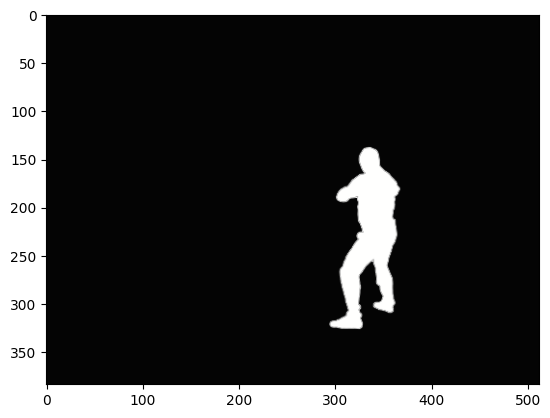

In [50]:
plt.imshow(mask)


In [51]:
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (min_x, min_y), (max_x, max_y), color, thickness)

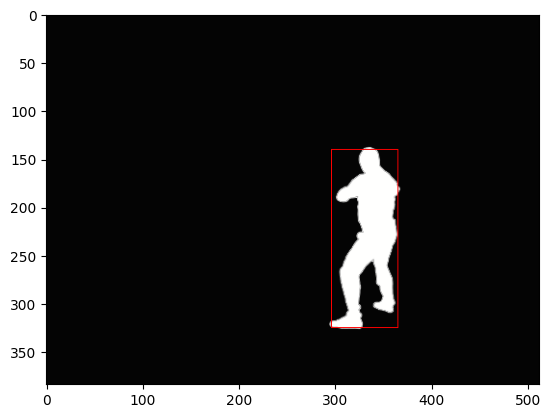

In [52]:
plt.imshow(crop_box)

In [53]:
import scipy
x_border_max = mask.shape[1]
y_border_max = mask.shape[0]

global_max_x = 0
global_min_x = x_border_max
global_max_y = 0
global_min_y = y_border_max

for mask_name in tqdm(mask_names):
    mask = cv2.imread(masks_path + '/' + mask_name)
    for row in range(len(mask)):
            for column in range(mask.shape[1]):
                    for channel in range(3):
                         if(mask[row][column][channel] == 255):
                            if(global_min_y > row):
                                global_min_y = row
                                global_min_y_image = mask_name
                            if(global_max_y < row):
                                global_max_y = row
                                global_max_y_image = mask_name
                            if(global_min_x > column):
                                global_min_x = column
                                global_min_x_image = mask_name
                            if(global_max_x < column):
                                global_max_x = column
                                global_max_x_image = mask_name

100%|██████████| 1193/1193 [26:35<00:00,  1.34s/it]


In [54]:
skip = True
if(skip):
  global_min_x = 28
  global_min_y = 52
  global_max_x = 473
  global_max_y = 383

In [55]:
print("The Crop Dimesions are ({0},{1}),({2},{3})".format(global_min_x, global_min_y, global_max_x, global_max_y))

The Crop Dimesions are (28,52),(473,383)


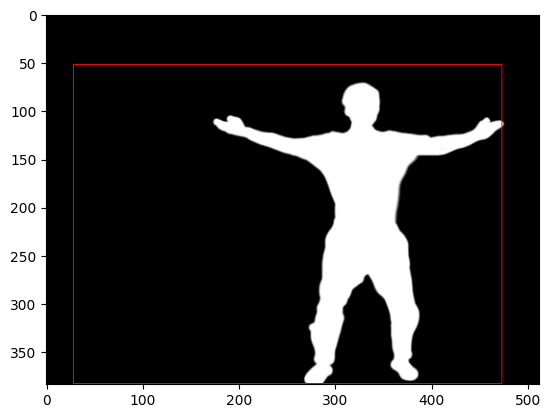

In [56]:
mask = cv2.imread(masks_path + "/" + global_max_x_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

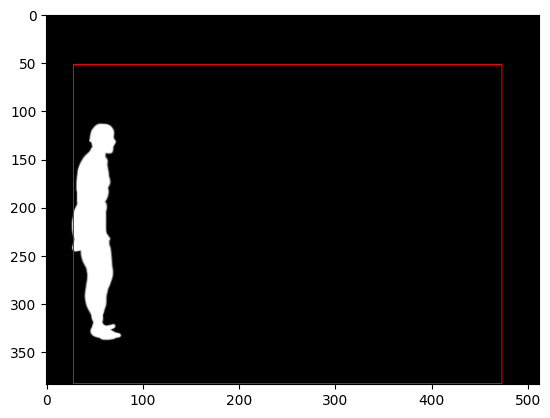

In [57]:
mask = cv2.imread(masks_path + "/" + global_min_x_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

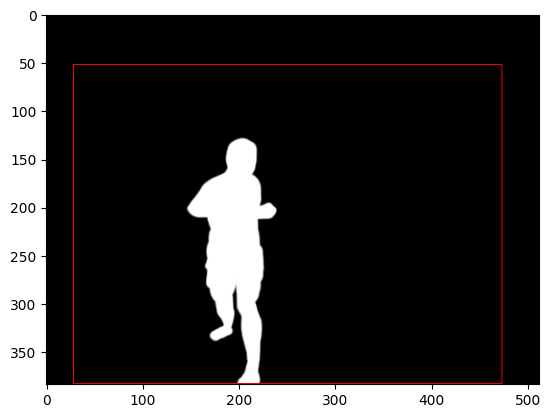

In [58]:
mask = cv2.imread(masks_path + "/" + global_max_y_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

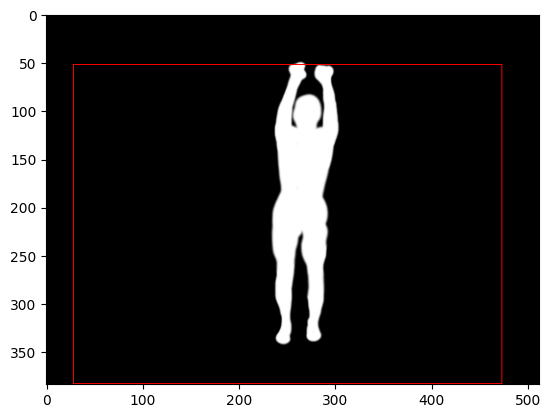

In [59]:
mask = cv2.imread(masks_path + "/" + global_min_y_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

In [60]:
class Dataset(Dataset):
    def __init__(self, names):
      self.names = names
    def __len__(self):
        return len(self.names)

    def transform_image(self, image):
        image = image[global_min_x - 15:global_max_x + 15, global_min_y - 15 : global_max_y + 15, :]
        image = cv2.resize(image,(128,128))
        image /= 255.0
        image = torch.as_tensor(image, dtype=torch.float32)
        image = torch.permute(image,(2,0,1))

        return image
    def transform_mask(self, mask):

        mask = mask[global_min_x - 15:global_max_x + 15, global_min_y - 15 : global_max_y + 15]
        mask = cv2.resize(mask,(128,128))
        mask[mask>0] = 1
        return mask

    def __getitem__(self, index):
        image = self.names[index]
        image = cv2.imread(os.path.join(images_path,image), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = self.transform_image(image)

        mask = self.names[index]
        mask = cv2.imread(os.path.join(masks_path,mask),cv2.IMREAD_GRAYSCALE)
        mask = self.transform_mask(mask)
        mask = torch.as_tensor(mask, dtype=torch.long)
        return image, mask

In [61]:
X_train, X_val, _, _ = train_test_split(image_names, image_names, test_size=.2, random_state=42)

In [62]:
len(X_val)

239

In [63]:
train_dataset = Dataset(X_train)
train_data_loader = DataLoader(train_dataset, batch_size= 6,  shuffle=True, num_workers=2)
val_dataset = Dataset(X_val)
val_data_loader = DataLoader(val_dataset, batch_size= 3, shuffle=True, num_workers=1)

In [64]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [65]:
train_dataset[0][1].shape

torch.Size([128, 128])

In [66]:
len(val_data_loader)

80

In [85]:
def train(data_loader, epoch):
    model.train()
    correct_train = 0
    log_interval = 50
    t_loss = 0



    for idx, (images, mask) in enumerate((data_loader)):
        images = images.to(device).float()
        mask = mask.to(device).long()

        outputs = model(images)

        loss = criterion(outputs, mask)
        optimizer.zero_grad()
        loss.backward()
        t_loss += loss
        optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            print('Training | epoch {0} | {1}/{2} batches | loss {3}'.format(epoch, idx, len(data_loader),t_loss/(idx + 1)))
    return t_loss

def eval(data_loader, epoch):

    correct_train = 0
    log_interval = 40
    t_loss = 0
    t_act = 0

    for idx, (images, mask) in enumerate((data_loader)):
        optimizer.zero_grad()
        images = images.to(device).float()
        mask = mask.to(device).long()

        outputs = model(images)

        probs = torch.log_softmax(outputs, dim = 1)
        _, tags = torch.max(probs, dim = 1)
        corrects = torch.eq(tags,mask).int()
        acc = corrects.sum()/corrects.numel()

        t_act += acc

        del probs
        del tags

        torch.cuda.empty_cache()


        del images
        loss = criterion(outputs, mask)
        del mask
        t_loss += loss

        if idx % log_interval == 0 and idx > 0:
            print('Validation | epoch {0} | {1}/{2} batches | accuracy {3} | loss {4}'.format(epoch, idx, len(data_loader),
            t_act / (idx + 1) ,t_loss / (idx + 1)))
            correct_train = 0
    return t_loss, t_act


In [86]:
len(train_data_loader)

159

In [87]:
device = torch.device('cuda')
lr_rate = 2e-5

model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=.0005)
criterion = nn.CrossEntropyLoss()

To_tr_loss = []
To_tr_acc = []
To_val_loss = []
To_val_acc = []

for epoch in range(0,15):
  tr_loss = train(train_data_loader, epoch)
  with torch.no_grad():
    val_loss, val_acc = eval(val_data_loader, epoch)
  To_tr_loss.append(tr_loss)
  To_val_loss.append(val_loss)
  To_val_acc.append(val_acc)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


Training | epoch 0 | 50/159 batches | loss 0.16351500153541565
Training | epoch 0 | 100/159 batches | loss 0.1205747053027153
Training | epoch 0 | 150/159 batches | loss 0.09300555288791656
Validation | epoch 0 | 40/80 batches | accuracy 0.9823921322822571 | loss 0.0689028799533844
Training | epoch 1 | 50/159 batches | loss 0.04397541657090187
Training | epoch 1 | 100/159 batches | loss 0.03488369286060333
Training | epoch 1 | 150/159 batches | loss 0.037572335451841354
Validation | epoch 1 | 40/80 batches | accuracy 0.9914629459381104 | loss 0.02569279633462429
Training | epoch 2 | 50/159 batches | loss 0.04003719985485077
Training | epoch 2 | 100/159 batches | loss 0.039018627256155014
Training | epoch 2 | 150/159 batches | loss 0.03249121829867363
Validation | epoch 2 | 40/80 batches | accuracy 0.9935348033905029 | loss 0.01879100687801838
Training | epoch 3 | 50/159 batches | loss 0.03746066242456436
Training | epoch 3 | 100/159 batches | loss 0.036660924553871155
Training | epoch 

In [88]:
torch.save(model.state_dict(), 'model.pth')

In [89]:
Total_train_loss = []
for i in To_tr_loss:
  Total_train_loss.append(i.item() / len(train_data_loader))
Total_val_loss = []
for i in To_val_loss:
  Total_val_loss.append(i.item() / len(val_data_loader))

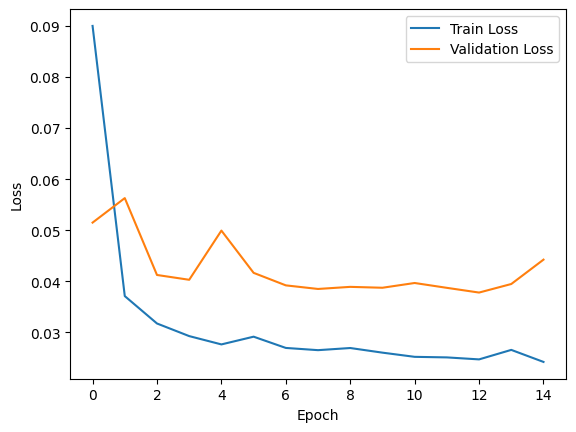

In [90]:
x = range(len(To_tr_loss))
plt.plot(x, Total_train_loss, label = "Train Loss")
plt.plot(x, Total_val_loss, label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [103]:
Total_val_acc = []
for i in To_val_acc:
  Total_val_acc.append(i.item() / len(val_data_loader))

In [104]:
len(Total_val_acc)

15

Text(0, 0.5, 'Loss')

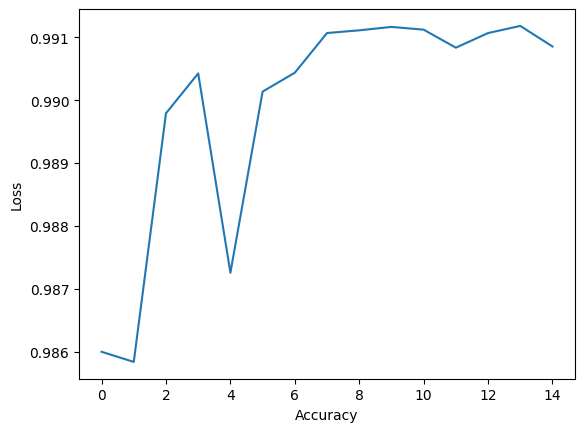

In [106]:
plt.plot(x, Total_val_acc, label = "Validation Accuracy")
plt.xlabel('Accuracy')
plt.ylabel('Loss')

In [107]:
#Applying Early Stopping at Epoch 13.

In [108]:
device = torch.device('cuda')
lr_rate = 2e-5

model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=.0005)
criterion = nn.CrossEntropyLoss()

To_tr_loss = []
To_tr_acc = []
To_val_loss = []
To_val_acc = []

for epoch in range(0,14):
  tr_loss = train(train_data_loader, epoch)
  with torch.no_grad():
    val_loss, val_acc = eval(val_data_loader, epoch)
  To_tr_loss.append(tr_loss)
  To_val_loss.append(val_loss)
  To_val_acc.append(val_acc)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


Training | epoch 0 | 50/159 batches | loss 0.1644754260778427
Training | epoch 0 | 100/159 batches | loss 0.10849983990192413
Training | epoch 0 | 150/159 batches | loss 0.09036717563867569
Validation | epoch 0 | 40/80 batches | accuracy 0.9800757169723511 | loss 0.07499322295188904
Training | epoch 1 | 50/159 batches | loss 0.0307537242770195
Training | epoch 1 | 100/159 batches | loss 0.02727072313427925
Training | epoch 1 | 150/159 batches | loss 0.03849827125668526
Validation | epoch 1 | 40/80 batches | accuracy 0.9918568730354309 | loss 0.024646662175655365
Training | epoch 2 | 50/159 batches | loss 0.03825262933969498
Training | epoch 2 | 100/159 batches | loss 0.037964362651109695
Training | epoch 2 | 150/159 batches | loss 0.03191402181982994
Validation | epoch 2 | 40/80 batches | accuracy 0.9924097657203674 | loss 0.021930113434791565
Training | epoch 3 | 50/159 batches | loss 0.035874392837285995
Training | epoch 3 | 100/159 batches | loss 0.026335671544075012
Training | epoc

In [110]:
Total_train_loss = []
for i in To_tr_loss:
  Total_train_loss.append(i.item() / len(train_data_loader))
Total_val_loss = []
for i in To_val_loss:
  Total_val_loss.append(i.item() / len(val_data_loader))

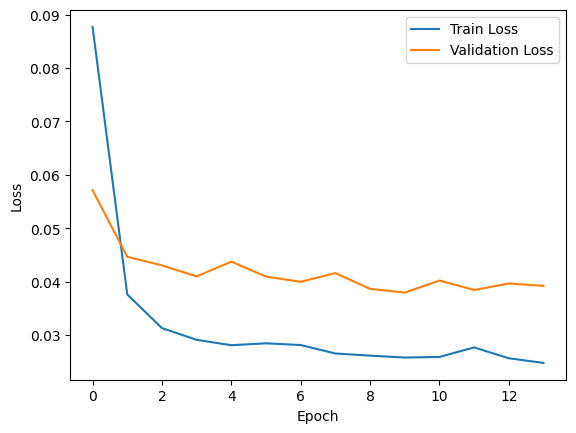

In [111]:
x = range(len(To_tr_loss))
plt.plot(x, Total_train_loss, label = "Train Loss")
plt.plot(x, Total_val_loss, label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [112]:
Total_val_acc = []
for i in To_val_acc:
  Total_val_acc.append(i.item() / len(val_data_loader))

Text(0, 0.5, 'Loss')

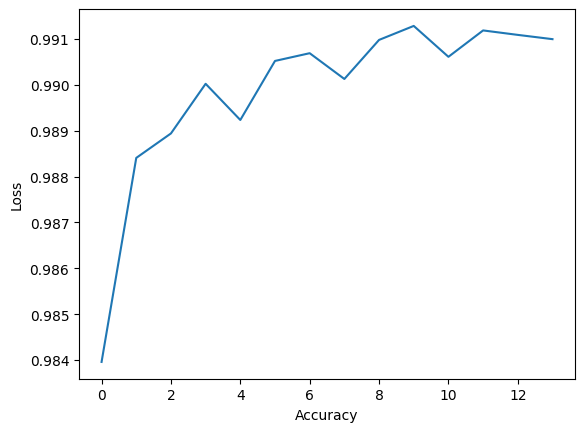

In [113]:
plt.plot(x, Total_val_acc, label = "Validation Accuracy")
plt.xlabel('Accuracy')
plt.ylabel('Loss')

In [114]:
torch.save(model.state_dict(), 'model.pth')